# Поиск аптамера в результатах нанопорового секвенирования

## 2025 ВМК МГУ, кафедра СКИ

## Студент: Никишкин Павел

## Научный руководитель: Григорьева Мария Александровна

In [1]:
!pip install biopython
!pip install isONclust
!pip install --upgrade git+https://github.com/huggingface/transformers.git
!pip install fuzzysearch
!pip install Levenshtein
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 22.2 MB/s eta 0:00:00
  Created wheel for isONclust: filename=isONclust-0.0.6.1-py2.py3-none-any.whl size=766695 sha256=8735ef6fbfe812f0032e7d0cd07faa8c0feb3a1276a17336a9299039e368dabc
  Stored in directory: /root/.cache/pip/wheels/22/a3/88/8515566aece679581b6716f00b7e488ebf827bacd8366eee93
Successfully built isONclust
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-swze1859
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-swze1859
  Resolved https://github.com/huggingface/transformers.git to commit 858ce6879a4aa7fa76a7c4e2ac20388e087ace26
  Installing b

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Первый этап - выделание последовательностей по праймерам.


Следующая функция ищет примерные вхождения одного из праймеров в исходном файле секвенирования и записиывает найденные цепочки в новый файл в формате fastq с сохраенением строки качества (это необходимо для применения алгоритма isONClust)

In [4]:
from Bio import SeqIO
from fuzzysearch import find_near_matches

def extract_aptamers(
    input_fastq: str,
    primer: str,
    output_fastq: str,
    max_error: int = 3,
    aptamer_length: int = 31,
    primer_length: int = 20,
    spacer: int = 3, # длина интервала запасных символов
    search_side: str = 'right'  # 'right' или 'left'
):
    assert search_side in ['right', 'left'], "search_side должен быть 'right' или 'left'"

    with open(output_fastq, 'w') as output_handle:
        for record in SeqIO.parse(input_fastq, 'fastq'):
            sequence = str(record.seq)
            quality = record.letter_annotations['phred_quality']
            quality_str = ''.join(chr(q + 33) for q in quality)

            matches = find_near_matches(primer, sequence, max_l_dist=max_error)
            for match in matches:
                if search_side == 'right':
                    right_index = match.start + primer_length
                    aptamer_start = right_index - aptamer_length - 2 * primer_length - spacer
                    aptamer_end = right_index
                else:  # search_side == 'left'
                    aptamer_start = match.end - primer_length
                    aptamer_end = match.end + aptamer_length + primer_length + spacer

                if aptamer_start < 0 or aptamer_end > len(sequence):
                    continue

                aptamer = sequence[aptamer_start:aptamer_end]
                aptamer_quality = quality_str[aptamer_start:aptamer_end]

                output_handle.write(f"@{record.id}_{aptamer_start}_{aptamer_end}\n{aptamer}\n+\n{aptamer_quality}\n")

Альтернативный подход для разделения записей сразу по двум праймерам -- левому и правому

(на наших данных работает не очень хорошо)

In [12]:
def extract_aptamers_between_primers(
    input_fastq: str,
    left_primer: str,
    right_primer: str,
    output_fastq: str,
    max_error: int = 1,
    min_between: int = 26, #Диапазон символов которые могут находиться между праймерами
    max_between: int = 36,
    left_len: int = 20,
    right_len: int = 20
):

    with open(output_fastq, 'w') as output_handle:
        for record in SeqIO.parse(input_fastq, 'fastq'):
            sequence = str(record.seq)
            quality = record.letter_annotations['phred_quality']
            quality_str = ''.join(chr(q + 33) for q in quality)

            left_matches = find_near_matches(left_primer, sequence, max_l_dist=max_error)

            for l_match in left_matches:
                l_end = l_match.end

                # Ограничим диапазон поиска правого праймера, чтобы не искать его во всей последовательности
                search_window = sequence[l_end : l_end + max_between + right_len]

                right_matches = find_near_matches(right_primer, search_window, max_l_dist=max_error)

                for r_match in right_matches:
                    between_len = r_match.start
                    if min_between <= between_len <= max_between:
                        r_start = l_end + r_match.start
                        r_end = r_start + right_len

                        full_start = l_match.start
                        full_end = r_end

                        if full_end > len(sequence):
                            continue

                        aptamer = sequence[full_start:full_end]
                        aptamer_quality = quality_str[full_start:full_end]

                        output_handle.write(f"@{record.id}_{full_start}_{full_end}\n{aptamer}\n+\n{aptamer_quality}\n")

Задаем параметры для поиска и выбираем один из методов

In [ ]:
input_fastq = 'barcode06.fastq'  # Путь к файлу с рузльтатми секвенирования
right_primer = 'GGCCCTAAAG'# Задаем участок правого пррймера 'GGCCCTAAAGCTTAGCACGA'
left_primer = 'CCTGCTCTCG'# Задаем участок левого пррймера 'CTTCATGGATCCTGCTCTCG'
output_fastq = 'aptamers_fuzzy.fastq'  # Имя файла, куда записываем обрезанные прайемры
max_error = 2  # Максимальное число ошибок

#Выибраем один из подходов для формирования цепочек -- по одному или по двум праймерам
extract_aptamers(input_fastq, right_primer, output_fastq, max_error)
#extract_aptamers_between_primers(input_fastq, left_primer, right_primer, output_fastq, max_error)

# Подход с кластеризацией isONclust
Начинаем кластеризацию isONclust.

Для наших данных нужны параметры --ont и --fastq

In [1]:
!isONclust --ont --fastq /content/aptamers_fuzzy.fastq --outfolder /content

/bin/bash: line 1: isONclust: command not found


Парсим цепочки днк в отдельные файлы по кластерам

In [16]:
from collections import defaultdict, Counter


# Парсит файл final_clusters.tsv и возвращает:
#        - словарь: read_id -> cluster_id
#        - счётчик: cluster_id -> количество ридов
def parse_clusters(cluster_file):
    read_to_cluster = {}
    cluster_counts = Counter()

    with open(cluster_file, 'r') as f:
        for line in f:
            cluster_id, read_id = line.strip().split()
            read_to_cluster[read_id] = cluster_id
            cluster_counts[cluster_id] += 1

    return read_to_cluster, cluster_counts

#Возвращает множество top-k кластеров по численности
def get_top_k_clusters(cluster_counts, k):
    return set([cluster_id for cluster_id, _ in cluster_counts.most_common(k)])

#Сохраняет только FASTQ-записи из top-k кластеров
def split_fastq_by_top_k_clusters(fastq_file, cluster_map, top_k_clusters):
    cluster_files = defaultdict(list)

    with open(fastq_file, 'r') as f:
        while True:
            lines = [f.readline() for _ in range(4)]
            if not lines[0]:
                break

            read_id = lines[0].strip().split()[0][1:]  # убираем '@'
            cluster_id = cluster_map.get(read_id)
            if cluster_id in top_k_clusters:
                cluster_files[cluster_id].append(''.join(lines))

    for cluster_id, reads in cluster_files.items():
        out_filename = f'cluster_{cluster_id}.fastq'
        with open(out_filename, 'w') as out_f:
            out_f.writelines(reads)


top_k = 10  # число кластеров, которые будем сохранять

cluster_map, cluster_counts = parse_clusters("final_clusters.tsv")
top_k_clusters = get_top_k_clusters(cluster_counts, top_k)
split_fastq_by_top_k_clusters("aptamers_fuzzy.fastq", cluster_map, top_k_clusters)

Функции для подсчета метрик полученных кластеров

In [17]:
import Levenshtein
from Bio import pairwise2
from Bio.Seq import Seq
from scipy.stats import entropy

def avg_alignment_score(cluster_sequences, method="global"):
    """Вычисляет средний скор выравнивания внутри кластера."""
    scores = []
    for i in range(len(cluster_sequences)):
        for j in range(i + 1, len(cluster_sequences)):
            seq1 = Seq(cluster_sequences[i])
            seq2 = Seq(cluster_sequences[j])
            if method == "global":
                alignment = pairwise2.align.globalxx(seq1, seq2, score_only=True)
            else:
                alignment = pairwise2.align.localxx(seq1, seq2, score_only=True)
            scores.append(alignment)
    return np.mean(scores) if scores else 0

def outlier_ratio(cluster_sequences, threshold=0.7):
    """Определяет долю выбросов в кластере, основываясь на средних расстояниях Левенштейна."""
    distances = []
    for i in range(len(cluster_sequences)):
        dists = [Levenshtein.distance(cluster_sequences[i], cluster_sequences[j])
                 for j in range(len(cluster_sequences)) if i != j]
        avg_dist = np.mean(dists) if dists else 0
        distances.append(avg_dist)

    max_dist = max(distances) if distances else 1
    if (max_dist == 0):
        max_dist = 1
    normalized_dists = [d / max_dist for d in distances]

    outliers = [1 for d in normalized_dists if d > threshold]
    return len(outliers) / len(cluster_sequences)

def alignment_entropy(cluster_sequences):
    """Вычисляет среднюю энтропию позиций в выравнивании."""
    alignment_matrix = list(zip(*cluster_sequences))  # Транспонируем список последовательностей
    entropies = []

    for col in alignment_matrix:
        freqs = np.array([col.count(nuc) / len(col) for nuc in "ATGC"])
        entropies.append(entropy(freqs, base=2))

    return np.mean(entropies)

Рассчитываем метрики качества полученных кластеров:

In [18]:
import glob
import os

#Читает только последовательности из FASTQ-файла
def read_sequences_from_fastq(fastq_path):
    sequences = []
    with open(fastq_path, 'r') as f:
        while True:
            header = f.readline()
            seq = f.readline().strip()
            plus = f.readline()
            qual = f.readline()
            if not header:
                break
            sequences.append(seq)
    return sequences

def analyze_cluster_fastq_files(fastq_dir='.', pattern='cluster_*.fastq'):
    data = []
    for file_path in sorted(glob.glob(os.path.join(fastq_dir, pattern))):
        cluster_id = os.path.splitext(os.path.basename(file_path))[0].split('_')[-1]
        seqs = read_sequences_from_fastq(file_path)
        if not seqs:
            continue
        row = {
            'cluster_file': os.path.basename(file_path),
            'cluster_id': cluster_id,
            'num_sequences': len(seqs),
            'avg_alignment_score': avg_alignment_score(seqs),
            'outlier_ratio': outlier_ratio(seqs),
            'alignment_entropy': alignment_entropy(seqs),
        }
        data.append(row)
    return pd.DataFrame(data).sort_values('num_sequences', ascending=False)

df = analyze_cluster_fastq_files()
print(df.to_string(index=False))

   cluster_file cluster_id  num_sequences  avg_alignment_score  outlier_ratio  alignment_entropy
cluster_0.fastq          0              2                 58.0            1.0           0.129032
cluster_1.fastq          1              2                 59.0            1.0           0.761905
cluster_2.fastq          2              1                  0.0            0.0           0.000000
cluster_3.fastq          3              1                  0.0            0.0           0.000000
cluster_4.fastq          4              1                  0.0            0.0           0.000000
cluster_5.fastq          5              1                  0.0            0.0           0.000000
cluster_6.fastq          6              1                  0.0            0.0           0.000000
cluster_7.fastq          7              1                  0.0            0.0           0.000000
cluster_8.fastq          8              1                  0.0            0.0           0.000000
cluster_9.fastq          9    

In [19]:
df_sorted = df.sort_values(
    by=["avg_alignment_score", "outlier_ratio", "alignment_entropy"],
    ascending=[False, True, True]
)

print(df_sorted.to_string(index=False))

   cluster_file cluster_id  num_sequences  avg_alignment_score  outlier_ratio  alignment_entropy
cluster_1.fastq          1              2                 59.0            1.0           0.761905
cluster_0.fastq          0              2                 58.0            1.0           0.129032
cluster_2.fastq          2              1                  0.0            0.0           0.000000
cluster_3.fastq          3              1                  0.0            0.0           0.000000
cluster_4.fastq          4              1                  0.0            0.0           0.000000
cluster_5.fastq          5              1                  0.0            0.0           0.000000
cluster_6.fastq          6              1                  0.0            0.0           0.000000
cluster_7.fastq          7              1                  0.0            0.0           0.000000
cluster_8.fastq          8              1                  0.0            0.0           0.000000
cluster_9.fastq          9    

Для равнозначного учета метрик рассчитываем усредненное значение всех метрик:
делаем scale и усредняем

In [20]:
from sklearn.preprocessing import MinMaxScaler

def combined_sort(df):

    scaler = MinMaxScaler()

    # Нормализация каждой метрики отдельно
    norm_score = scaler.fit_transform(df[["avg_alignment_score"]])
    norm_outlier = scaler.fit_transform(df[["outlier_ratio"]])
    norm_entropy = scaler.fit_transform(df[["alignment_entropy"]])

    # Инверсия score, т.к. для неё сортировка по убыванию (больше — лучше)
    norm_score_inv = 1 - norm_score

    # Усреднённая комбинированная метрика
    combined_score = (norm_score_inv.flatten() + norm_outlier.flatten() + norm_entropy.flatten()) / 3
    df["combined_score"] = combined_score

    # Сортируем по комбинированной метрике (чем меньше — тем лучше)
    df_sorted = df.sort_values("combined_score")

    return df_sorted.reset_index(drop=True)

df_sorted = combined_sort(df)
print(df_sorted)

      cluster_file cluster_id  num_sequences  avg_alignment_score  \
0  cluster_3.fastq          3              1                  0.0   
1  cluster_2.fastq          2              1                  0.0   
2  cluster_5.fastq          5              1                  0.0   
3  cluster_4.fastq          4              1                  0.0   
4  cluster_6.fastq          6              1                  0.0   
5  cluster_7.fastq          7              1                  0.0   
6  cluster_9.fastq          9              1                  0.0   
7  cluster_8.fastq          8              1                  0.0   
8  cluster_0.fastq          0              2                 58.0   
9  cluster_1.fastq          1              2                 59.0   

   outlier_ratio  alignment_entropy  combined_score  
0            0.0           0.000000        0.333333  
1            0.0           0.000000        0.333333  
2            0.0           0.000000        0.333333  
3            0.0        

По совокупности полученных метрик выбираем файлы, которые отправим на множественное выравнивание и визуализцаю в jalview

Для Jalview файлы должны быть конвертированы в fasta

In [11]:
def fastq_to_fasta(fastq_file, fasta_file):
    with open(fasta_file, "w") as fasta_out:
        for record in SeqIO.parse(fastq_file, "fastq"):
            SeqIO.write(record, fasta_out, "fasta")

#выбираем имена файлов с лучшими кластерами и переводим в формат FASTA
fastq_to_fasta("cluster_0.fastq", "cluster_0.fasta")
fastq_to_fasta("cluster_6.fastq", "cluster_6.fasta")
fastq_to_fasta("cluster_1.fastq", "cluster_1.fasta")

#Подход с получением эмбеддингов
Для начала собираем список из строк цепочек

In [8]:
def extract_dna_sequences_from_fastq(file_path):
    dna_sequences = []

    with open(file_path, 'r') as fastq_file:
        while True:
            header = fastq_file.readline().strip()
            if not header:
                break
            sequence = fastq_file.readline().strip()  # Чтение строки с последовательностью
            fastq_file.readline()  # Пропуск строки с символом "+"
            fastq_file.readline()  # Пропуск строки с качеством
            dna_sequences.append(sequence)

    return dna_sequences


fastq_file_path = 'aptamers_fuzzy.fastq'
dna_sequences = extract_dna_sequences_from_fastq(fastq_file_path)

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

MODEL_NAME = "InstaDeepAI/nucleotide-transformer-500m-human-ref" #Есть возможность выбрать модель больше, до 2.5B параметров

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(seqs, batch_size=2, max_length=512):
    embeddings = []
    for i in tqdm(range(0, len(seqs), batch_size)):
        batch_seqs = seqs[i:i+batch_size]
        # Токенизация
        inputs = tokenizer(batch_seqs, return_tensors="pt", padding="max_length",
                           truncation=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Получение эмбеддингов
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            # Пуллинг — среднее по длине
            mean_embedding = last_hidden_state.mean(dim=1)
            embeddings.extend(mean_embedding.cpu().numpy())
    return embeddings

mean_sequence_embeddings = get_embeddings(dna_sequences)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

100%|██████████| 1375/1375 [06:28<00:00,  3.54it/s]


NameError: name 'embeddings' is not defined

In [10]:
print(f"Получено эмбеддингов: {len(mean_sequence_embeddings)}")
print(f"Форма одного эмбеддинга: {mean_sequence_embeddings[0].shape}")

Получено эмбеддингов: 2749
Форма одного эмбеддинга: (1280,)


In [24]:
mean_sequence_embeddings = np.array(mean_sequence_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Найдено кластеров: 7


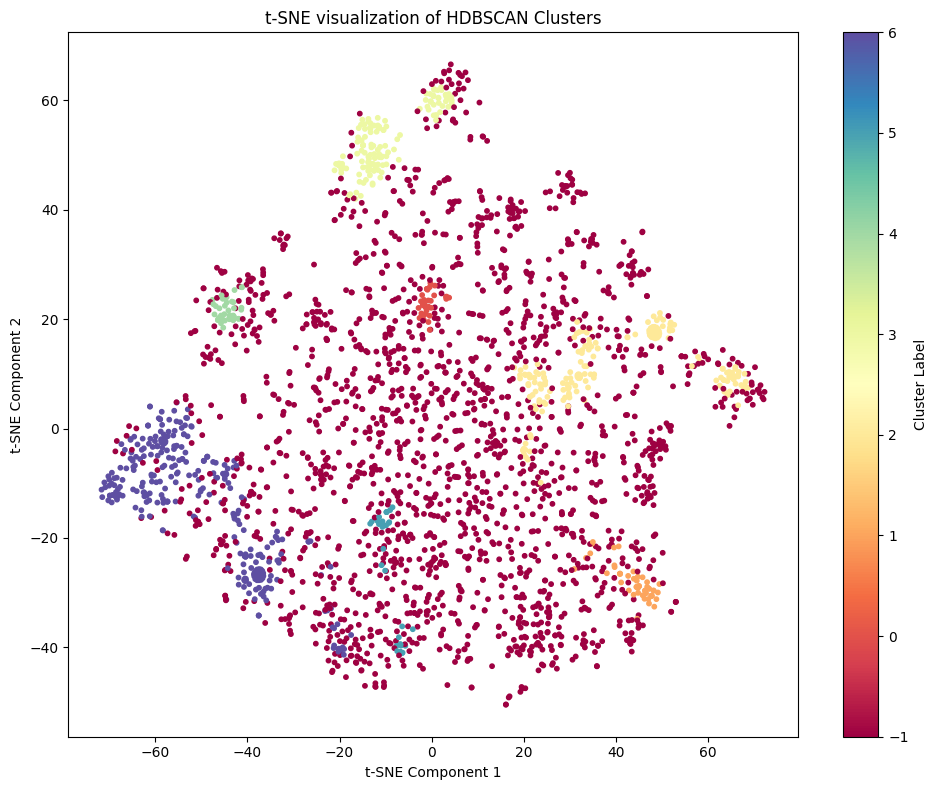

In [21]:
import hdbscan
from sklearn.manifold import TSNE

# Выполняем кластеризацию с HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10)
labels = clusterer.fit_predict(mean_sequence_embeddings)

# Количество найденных кластеров (-1 означает шум)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Найдено кластеров: {n_clusters}")

# Визуализация с t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, init='pca')
reduced_embeddings = tsne.fit_transform(mean_sequence_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral', s=10)
plt.title('t-SNE visualization of HDBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.tight_layout()
plt.show()


In [22]:
unique_labels, counts = np.unique(labels, return_counts=True)

# Вывод размеров кластеров
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"Шум (не попали в кластеры): {count} точек")
    else:
        print(f"Кластер {label}: {count} точек")

Шум (не попали в кластеры): 1977 точек
Кластер 0: 33 точек
Кластер 1: 53 точек
Кластер 2: 183 точек
Кластер 3: 131 точек
Кластер 4: 38 точек
Кластер 5: 32 точек
Кластер 6: 302 точек


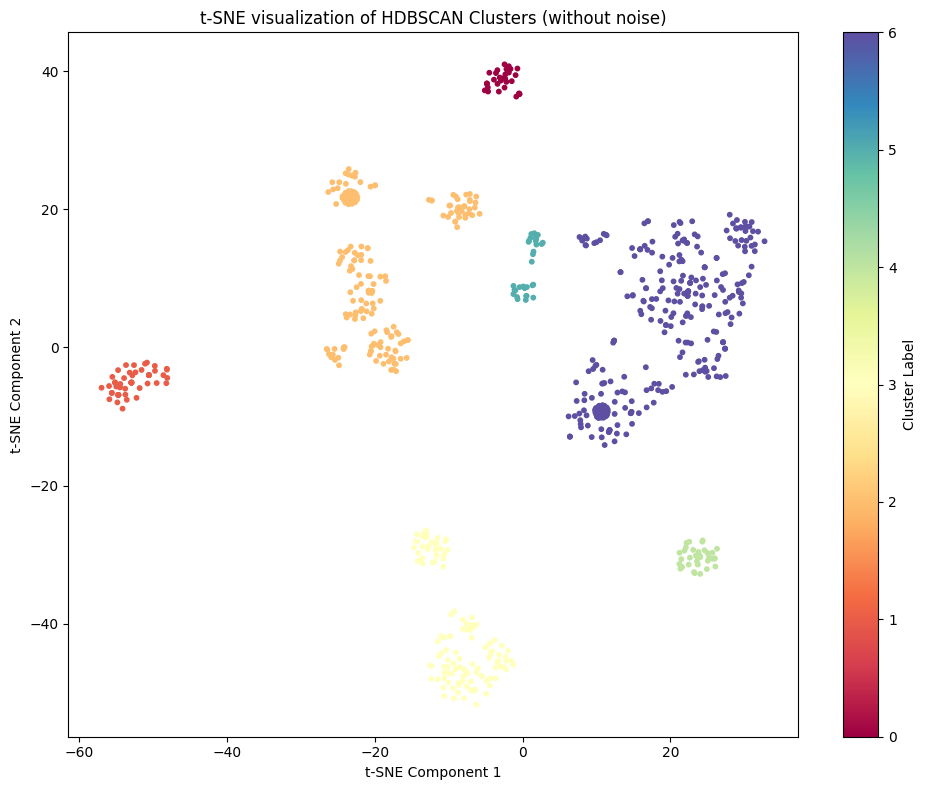

In [26]:
# Исключаем шумовые точки (-1)
mask = labels != -1
filtered_embeddings = mean_sequence_embeddings[mask]
filtered_labels = labels[mask]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, init='pca')
reduced_embeddings = tsne.fit_transform(filtered_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=filtered_labels,
    cmap='Spectral',
    s=10
)
plt.title('t-SNE visualization of HDBSCAN Clusters (without noise)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.tight_layout()
plt.show()


In [31]:
from collections import defaultdict

clusters = defaultdict(list)
for seq, label in zip(dna_sequences, labels):
    if label != -1:  # Игнорируем шум
        clusters[label].append(seq)

# Вычисляем среднее качество кластеров
avg_alignment_scores = {label: avg_alignment_score(sequences) for label, sequences in clusters.items()}

# Выводим результаты
for cluster, score in avg_alignment_scores.items():
    print(f"Кластер {cluster}: avg alignment score = {score:.2f}")

Кластер 4: avg alignment score = 70.80
Кластер 6: avg alignment score = 69.70
Кластер 2: avg alignment score = 69.37
Кластер 1: avg alignment score = 71.81
Кластер 0: avg alignment score = 70.30
Кластер 3: avg alignment score = 68.34
Кластер 5: avg alignment score = 69.52


In [32]:
outlier_ratio_scores = {label: outlier_ratio(sequences) for label, sequences in clusters.items()}

# Выводим результаты
for cluster, score in outlier_ratio_scores.items():
    print(f"Кластер {cluster}: outlier ratio score = {score:.2f}")

Кластер 4: outlier ratio score = 0.16
Кластер 6: outlier ratio score = 0.12
Кластер 2: outlier ratio score = 0.04
Кластер 1: outlier ratio score = 0.08
Кластер 0: outlier ratio score = 0.06
Кластер 3: outlier ratio score = 0.18
Кластер 5: outlier ratio score = 0.38


In [33]:
alignment_entropy_scores = {label: alignment_entropy(sequences) for label, sequences in clusters.items()}

# Выводим результаты
for cluster, score in alignment_entropy_scores.items():
    print(f"Кластер {cluster}: alignment entropy = {score:.2f}")

Кластер 4: alignment entropy = 0.53
Кластер 6: alignment entropy = 0.65
Кластер 2: alignment entropy = 0.85
Кластер 1: alignment entropy = 0.39
Кластер 0: alignment entropy = 0.48
Кластер 3: alignment entropy = 0.88
Кластер 5: alignment entropy = 0.68


In [37]:
def combined_sort_from_dicts(avg_alignment_scores, outlier_ratio_scores, alignment_entropy_scores):
    # Собираем DataFrame из словарей (по ключам avg_alignment_scores)
    df = pd.DataFrame({
        "cluster_id": list(avg_alignment_scores.keys()),
        "avg_alignment_score": list(avg_alignment_scores.values()),
        "outlier_ratio": [outlier_ratio_scores.get(cid, 0) for cid in avg_alignment_scores.keys()],
        "alignment_entropy": [alignment_entropy_scores.get(cid, 0) for cid in avg_alignment_scores.keys()]
    })

    scaler = MinMaxScaler()

    norm_score = scaler.fit_transform(df[["avg_alignment_score"]])
    norm_outlier = scaler.fit_transform(df[["outlier_ratio"]])
    norm_entropy = scaler.fit_transform(df[["alignment_entropy"]])

    # Инверсия score, т.к. для неё сортировка по убыванию (больше — лучше)
    norm_score_inv = 1 - norm_score

    # Усреднённая комбинированная метрика
    combined_score = (norm_score_inv.flatten() + norm_outlier.flatten() + norm_entropy.flatten()) / 3

    # Добавляем комбинированную метрику во временный DataFrame
    df["combined_score"] = combined_score

    # Сортируем по комбинированной метрике (чем меньше — тем лучше)
    df_sorted = df.sort_values("combined_score")

    return df_sorted.reset_index(drop=True)

df_sorted = combined_sort_from_dicts(avg_alignment_scores, outlier_ratio_scores, alignment_entropy_scores)
print(df_sorted.to_string(index=False))

 cluster_id  avg_alignment_score  outlier_ratio  alignment_entropy  combined_score
          1            71.806241       0.075472           0.386175        0.031952
          0            70.301136       0.060606           0.475596        0.222025
          4            70.796586       0.157895           0.525617        0.305879
          6            69.701899       0.115894           0.649021        0.452007
          2            69.374527       0.043716           0.853721        0.548608
          5            69.520161       0.375000           0.683856        0.753645
          3            68.343159       0.183206           0.881645        0.807020


In [38]:
def write_fastq_by_clusters(fastq_file, clusters, output_prefix="cluster_"):
    # Создаем индекс: последовательность -> список записей (на случай одинаковых последовательностей)
    sequence_to_records = defaultdict(list)
    for record in SeqIO.parse(fastq_file, "fastq"):
        sequence_to_records[str(record.seq)].append(record)

    # Для каждого кластера — создаем fastq файл
    for cluster_id, seq_list in clusters.items():
        output_file = f"{output_prefix}{cluster_id}.fastq"
        written_records = []

        for seq in seq_list:
            if sequence_to_records[seq]:
                written_records.append(sequence_to_records[seq].pop(0))  # берем и удаляем первую подходящую запись

        if written_records:
            with open(output_file, "w") as out_f:
                SeqIO.write(written_records, out_f, "fastq")

write_fastq_by_clusters('aptamers_fuzzy.fastq', clusters)

In [39]:
def fastq_to_fasta(fastq_file, fasta_file):
    with open(fasta_file, "w") as fasta_out:
        for record in SeqIO.parse(fastq_file, "fastq"):
            SeqIO.write(record, fasta_out, "fasta")

fastq_to_fasta("cluster_0.fastq", "cluster_0.fasta")
fastq_to_fasta("cluster_1.fastq", "cluster_1.fasta")